In [25]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2_full.bin"

In [2]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')

In [26]:
from ast import FloorDiv
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [27]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos.csv')

In [28]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [29]:
# replace all -1 to 2 since pytorch cannot handle negative
# so, 2 now means negative polarity
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 3


0

In [30]:
print(len(sentences))
print(len(aspect_tags))
print(len(polarity_tags))

3432
3432
3432


In [31]:
print(max(map(lambda x: len(x), sentences)))

84


In [36]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, pol_tags, sent_len=85):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                if aspect_tags[sx][wx] == 0:
                    mask[sx, wx] = 1
                elif aspect_tags[sx][wx] == 1:
                    mask[sx, wx] = 0
                train_y[sx, wx] = pol_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label, num_tag):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, num_tag)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [33]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)

    def forward(self, x_train):
        x_emb = self.gen_embedding(x_train)

        output, (h_n, _) = self.lstm(x_emb.float())
        out = self.dense(output)

        return out

In [38]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, polarity_tags, sent_len=85)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [40]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2745
valid samples:687


In [41]:
history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()
        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]



epoch 0
	train_loss:1.062 valid_loss:1.038
	train_acc:50.64% valid_acc:50.12%
	train_f1:0.505 valid_f1:0.469
	train_confusion_matrix:
[[  36 1104  141]
 [ 125 3121  407]
 [  53 1512  272]]
	valid_confusion_matrix:
[[  0 362   3]
 [  0 856   6]
 [  0 486   5]]


100%|██████████| 1/1 [00:00<00:00,  2.58it/s]



epoch 1
	train_loss:1.002 valid_loss:1.008
	train_acc:54.12% valid_acc:50.29%
	train_f1:0.520 valid_f1:0.470
	train_confusion_matrix:
[[   0 1283    0]
 [   0 3664    0]
 [   0 1826    4]]
	valid_confusion_matrix:
[[  0 365   0]
 [  0 862   0]
 [  0 489   2]]


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



epoch 2
	train_loss:0.969 valid_loss:0.994
	train_acc:54.13% valid_acc:50.58%
	train_f1:0.520 valid_f1:0.471
	train_confusion_matrix:
[[   0 1281    1]
 [   0 3661    0]
 [   0 1827    8]]
	valid_confusion_matrix:
[[  0 363   2]
 [  0 861   1]
 [  0 483   8]]


100%|██████████| 1/1 [00:00<00:00,  2.71it/s]



epoch 3
	train_loss:0.951 valid_loss:0.983
	train_acc:54.43% valid_acc:51.92%
	train_f1:0.520 valid_f1:0.477
	train_confusion_matrix:
[[   0 1278   10]
 [   0 3644    7]
 [   0 1793   44]]
	valid_confusion_matrix:
[[  0 352  13]
 [  0 858   4]
 [  0 457  34]]


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]



epoch 4
	train_loss:0.929 valid_loss:0.964
	train_acc:57.55% valid_acc:55.65%
	train_f1:0.536 valid_f1:0.493
	train_confusion_matrix:
[[   0 1148  133]
 [   0 3585   75]
 [   0 1521  315]]
	valid_confusion_matrix:
[[  0 312  53]
 [  0 832  30]
 [  0 367 124]]


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]



epoch 5
	train_loss:0.899 valid_loss:0.945
	train_acc:60.61% valid_acc:57.63%
	train_f1:0.553 valid_f1:0.502
	train_confusion_matrix:
[[   1 1015  266]
 [   1 3532  129]
 [   0 1257  573]]
	valid_confusion_matrix:
[[  0 289  76]
 [  0 818  44]
 [  0 319 172]]


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]



epoch 6
	train_loss:0.858 valid_loss:0.918
	train_acc:62.66% valid_acc:59.14%
	train_f1:0.570 valid_f1:0.511
	train_confusion_matrix:
[[   8  895  367]
 [   1 3479  186]
 [   1 1079  757]]
	valid_confusion_matrix:
[[  2 244 119]
 [  1 762  99]
 [  0 239 252]]


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]



epoch 7
	train_loss:0.825 valid_loss:0.900
	train_acc:64.02% valid_acc:60.13%
	train_f1:0.576 valid_f1:0.531
	train_confusion_matrix:
[[   9  746  511]
 [   1 3236  388]
 [   3  773 1065]]
	valid_confusion_matrix:
[[ 12 210 143]
 [  0 725 137]
 [  2 193 296]]


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]



epoch 8
	train_loss:0.780 valid_loss:0.889
	train_acc:66.11% valid_acc:62.28%
	train_f1:0.611 valid_f1:0.558
	train_confusion_matrix:
[[  63  647  564]
 [   6 3257  384]
 [  12  679 1152]]
	valid_confusion_matrix:
[[ 25 232 108]
 [  1 766  95]
 [  6 206 279]]


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]



epoch 9
	train_loss:0.752 valid_loss:0.859
	train_acc:67.79% valid_acc:63.15%
	train_f1:0.641 valid_f1:0.576
	train_confusion_matrix:
[[ 135  619  534]
 [  25 3297  351]
 [  35  627 1179]]
	valid_confusion_matrix:
[[ 38 216 111]
 [ 11 746 105]
 [ 11 179 301]]


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]



epoch 10
	train_loss:0.730 valid_loss:0.830
	train_acc:69.40% valid_acc:64.20%
	train_f1:0.672 valid_f1:0.604
	train_confusion_matrix:
[[ 205  543  530]
 [  56 3285  344]
 [  67  533 1212]]
	valid_confusion_matrix:
[[ 57 194 114]
 [ 20 736 106]
 [ 28 153 310]]


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]



epoch 11
	train_loss:0.703 valid_loss:0.834
	train_acc:69.92% valid_acc:63.80%
	train_f1:0.687 valid_f1:0.596
	train_confusion_matrix:
[[ 265  562  453]
 [  71 3335  281]
 [ 121  554 1147]]
	valid_confusion_matrix:
[[ 54 223  88]
 [ 21 761  80]
 [ 26 184 281]]


100%|██████████| 1/1 [00:00<00:00,  2.77it/s]



epoch 12
	train_loss:0.685 valid_loss:0.817
	train_acc:71.63% valid_acc:64.73%
	train_f1:0.711 valid_f1:0.614
	train_confusion_matrix:
[[ 329  472  470]
 [  79 3271  312]
 [ 133  457 1256]]
	valid_confusion_matrix:
[[ 67 200  98]
 [ 26 745  91]
 [ 32 159 300]]


100%|██████████| 1/1 [00:00<00:00,  2.61it/s]



epoch 13
	train_loss:0.671 valid_loss:0.801
	train_acc:72.19% valid_acc:65.60%
	train_f1:0.718 valid_f1:0.623
	train_confusion_matrix:
[[ 359  466  456]
 [  90 3266  308]
 [ 125  438 1264]]
	valid_confusion_matrix:
[[ 71 194 100]
 [ 29 746  87]
 [ 38 143 310]]


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]



epoch 14
	train_loss:0.655 valid_loss:0.785
	train_acc:73.09% valid_acc:66.65%
	train_f1:0.733 valid_f1:0.643
	train_confusion_matrix:
[[ 406  425  444]
 [ 103 3277  281]
 [ 148  421 1266]]
	valid_confusion_matrix:
[[ 89 168 108]
 [ 38 727  97]
 [ 37 125 329]]


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]



epoch 15
	train_loss:0.641 valid_loss:0.794
	train_acc:73.59% valid_acc:66.53%
	train_f1:0.739 valid_f1:0.630
	train_confusion_matrix:
[[ 442  407  426]
 [ 142 3252  250]
 [ 172  390 1286]]
	valid_confusion_matrix:
[[ 75 203  87]
 [ 27 760  75]
 [ 30 153 308]]


100%|██████████| 1/1 [00:00<00:00,  2.73it/s]



epoch 16
	train_loss:0.626 valid_loss:0.773
	train_acc:74.37% valid_acc:67.81%
	train_f1:0.741 valid_f1:0.664
	train_confusion_matrix:
[[ 407  417  447]
 [  99 3292  253]
 [ 126  388 1320]]
	valid_confusion_matrix:
[[118 164  83]
 [ 56 729  77]
 [ 44 129 318]]


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]



epoch 17
	train_loss:0.615 valid_loss:0.773
	train_acc:74.80% valid_acc:67.17%
	train_f1:0.754 valid_f1:0.651
	train_confusion_matrix:
[[ 501  371  420]
 [ 142 3238  259]
 [ 156  359 1328]]
	valid_confusion_matrix:
[[101 171  93]
 [ 51 732  79]
 [ 40 130 321]]


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]



epoch 18
	train_loss:0.598 valid_loss:0.767
	train_acc:75.88% valid_acc:67.87%
	train_f1:0.763 valid_f1:0.666
	train_confusion_matrix:
[[ 501  367  420]
 [ 122 3297  243]
 [ 131  349 1337]]
	valid_confusion_matrix:
[[122 147  96]
 [ 62 706  94]
 [ 45 108 338]]


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


epoch 19
	train_loss:0.589 valid_loss:0.774
	train_acc:75.81% valid_acc:67.93%
	train_f1:0.771 valid_f1:0.657
	train_confusion_matrix:
[[ 567  330  383]
 [ 150 3257  265]
 [ 185  328 1318]]
	valid_confusion_matrix:
[[ 98 146 121]
 [ 46 711 105]
 [ 31 102 358]]


---

In [42]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2_full_clean.bin"

In [43]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')

In [44]:
from ast import FloorDiv
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report

In [45]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_cleaned.csv')

In [46]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [47]:
# replace all -1 to 2 since pytorch cannot handle negative
# so, 2 now means negative polarity
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 3


0

In [48]:
print(len(sentences))
print(len(aspect_tags))
print(len(polarity_tags))

3432
3432
3432


In [49]:
print(max(map(lambda x: len(x), sentences)))

80


In [51]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, pol_tags, sent_len=85):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                if aspect_tags[sx][wx] == 0:
                    mask[sx, wx] = 1
                elif aspect_tags[sx][wx] == 1:
                    mask[sx, wx] = 0
                train_y[sx, wx] = pol_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label, num_tag):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, num_tag)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [76]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)

    def forward(self, x_train):
        x_emb = self.gen_embedding(x_train)

        output, (h_n, _) = self.lstm(x_emb.float())
        out = self.dense(output)

        return out

In [57]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, polarity_tags, sent_len=83)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [77]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2745
valid samples:687


In [78]:
history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()
        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())


100%|██████████| 1/1 [00:00<00:00,  2.10it/s]



epoch 0
	train_loss:1.064 valid_loss:1.039
	train_acc:49.63% valid_acc:50.24%
	train_f1:0.526 valid_f1:0.459
	train_confusion_matrix:
[[ 128 1009  108]
 [ 361 3031  206]
 [ 155 1537  167]]
	valid_confusion_matrix:
[[  0 384   2]
 [  0 838  11]
 [  0 439   6]]


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]



epoch 1
	train_loss:0.999 valid_loss:1.009
	train_acc:54.42% valid_acc:50.42%
	train_f1:0.526 valid_f1:0.460
	train_confusion_matrix:
[[   0 1219    9]
 [   1 3627    9]
 [   0 1826   31]]
	valid_confusion_matrix:
[[  0 385   1]
 [  0 842   7]
 [  0 440   5]]


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]



epoch 2
	train_loss:0.966 valid_loss:0.999
	train_acc:54.11% valid_acc:50.71%
	train_f1:0.522 valid_f1:0.460
	train_confusion_matrix:
[[   0 1224   10]
 [   0 3603    7]
 [   0 1842   32]]
	valid_confusion_matrix:
[[  0 385   1]
 [  0 839  10]
 [  0 432  13]]


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]



epoch 3
	train_loss:0.943 valid_loss:0.988
	train_acc:55.41% valid_acc:52.50%
	train_f1:0.528 valid_f1:0.470
	train_confusion_matrix:
[[   0 1197   53]
 [   0 3606   21]
 [   0 1725  117]]
	valid_confusion_matrix:
[[  0 357  29]
 [  0 831  18]
 [  0 394  51]]


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]



epoch 4
	train_loss:0.921 valid_loss:0.972
	train_acc:58.30% valid_acc:55.65%
	train_f1:0.545 valid_f1:0.484
	train_confusion_matrix:
[[   0  982  250]
 [   0 3468  149]
 [   0 1419  447]]
	valid_confusion_matrix:
[[  0 311  75]
 [  0 795  54]
 [  0 305 140]]


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]



epoch 5
	train_loss:0.893 valid_loss:0.953
	train_acc:60.61% valid_acc:57.80%
	train_f1:0.560 valid_f1:0.495
	train_confusion_matrix:
[[   1  849  387]
 [   0 3388  237]
 [   0 1171  679]]
	valid_confusion_matrix:
[[  0 288  98]
 [  0 786  63]
 [  0 260 185]]


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]



epoch 6
	train_loss:0.855 valid_loss:0.928
	train_acc:63.21% valid_acc:60.36%
	train_f1:0.577 valid_f1:0.512
	train_confusion_matrix:
[[  17  762  462]
 [   0 3275  348]
 [   0  896  948]]
	valid_confusion_matrix:
[[  2 260 124]
 [  0 771  78]
 [  0 204 241]]


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]



epoch 7
	train_loss:0.816 valid_loss:0.905
	train_acc:64.96% valid_acc:61.85%
	train_f1:0.595 valid_f1:0.521
	train_confusion_matrix:
[[  35  686  500]
 [   1 3226  381]
 [   4  774 1088]]
	valid_confusion_matrix:
[[  5 271 110]
 [  0 778  71]
 [  1 188 256]]


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]



epoch 8
	train_loss:0.777 valid_loss:0.859
	train_acc:66.44% valid_acc:63.27%
	train_f1:0.616 valid_f1:0.548
	train_confusion_matrix:
[[  66  623  551]
 [   8 3236  394]
 [  11  675 1177]]
	valid_confusion_matrix:
[[ 16 231 139]
 [  1 755  93]
 [  4 149 292]]


100%|██████████| 1/1 [00:00<00:00,  1.90it/s]



epoch 9
	train_loss:0.752 valid_loss:0.831
	train_acc:68.05% valid_acc:63.69%
	train_f1:0.639 valid_f1:0.566
	train_confusion_matrix:
[[ 115  615  518]
 [  26 3253  354]
 [  23  611 1205]]
	valid_confusion_matrix:
[[ 27 214 145]
 [  4 743 102]
 [ 11 134 300]]


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]



epoch 10
	train_loss:0.729 valid_loss:0.814
	train_acc:69.14% valid_acc:64.11%
	train_f1:0.662 valid_f1:0.591
	train_confusion_matrix:
[[ 161  550  498]
 [  53 3226  335]
 [  51  577 1237]]
	valid_confusion_matrix:
[[ 47 204 135]
 [  6 739 104]
 [ 19 135 291]]


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]



epoch 11
	train_loss:0.713 valid_loss:0.810
	train_acc:69.85% valid_acc:64.11%
	train_f1:0.673 valid_f1:0.594
	train_confusion_matrix:
[[ 206  531  508]
 [  58 3194  373]
 [  62  495 1297]]
	valid_confusion_matrix:
[[ 50 225 111]
 [ 10 770  69]
 [ 28 160 257]]


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]



epoch 12
	train_loss:0.687 valid_loss:0.803
	train_acc:70.78% valid_acc:64.35%
	train_f1:0.692 valid_f1:0.602
	train_confusion_matrix:
[[ 258  534  435]
 [  76 3231  310]
 [ 123  478 1249]]
	valid_confusion_matrix:
[[ 57 221 108]
 [ 13 763  73]
 [ 32 152 261]]


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]



epoch 13
	train_loss:0.673 valid_loss:0.792
	train_acc:71.57% valid_acc:64.94%
	train_f1:0.703 valid_f1:0.608
	train_confusion_matrix:
[[ 291  470  472]
 [  98 3194  322]
 [ 123  428 1330]]
	valid_confusion_matrix:
[[ 60 215 111]
 [ 11 761  77]
 [ 32 143 270]]


100%|██████████| 1/1 [00:00<00:00,  1.89it/s]



epoch 14
	train_loss:0.653 valid_loss:0.789
	train_acc:72.83% valid_acc:65.54%
	train_f1:0.714 valid_f1:0.623
	train_confusion_matrix:
[[ 302  486  439]
 [  81 3266  282]
 [ 101  432 1313]]
	valid_confusion_matrix:
[[ 73 206 107]
 [ 17 755  77]
 [ 39 133 273]]


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]



epoch 15
	train_loss:0.638 valid_loss:0.805
	train_acc:73.40% valid_acc:64.70%
	train_f1:0.730 valid_f1:0.617
	train_confusion_matrix:
[[ 379  425  419]
 [ 130 3200  294]
 [ 149  370 1352]]
	valid_confusion_matrix:
[[ 71 224  91]
 [ 15 773  61]
 [ 50 152 243]]


100%|██████████| 1/1 [00:00<00:00,  2.27it/s]



epoch 16
	train_loss:0.628 valid_loss:0.781
	train_acc:73.90% valid_acc:65.65%
	train_f1:0.732 valid_f1:0.640
	train_confusion_matrix:
[[ 375  434  427]
 [ 120 3214  260]
 [ 139  363 1347]]
	valid_confusion_matrix:
[[ 96 214  76]
 [ 25 767  57]
 [ 58 147 240]]


100%|██████████| 1/1 [00:00<00:00,  2.56it/s]



epoch 17
	train_loss:0.623 valid_loss:0.764
	train_acc:73.98% valid_acc:67.56%
	train_f1:0.740 valid_f1:0.646
	train_confusion_matrix:
[[ 412  422  395]
 [ 123 3250  246]
 [ 152  405 1294]]
	valid_confusion_matrix:
[[ 89 184 113]
 [ 18 734  97]
 [ 34  99 312]]


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]



epoch 18
	train_loss:0.606 valid_loss:0.758
	train_acc:75.27% valid_acc:67.44%
	train_f1:0.752 valid_f1:0.657
	train_confusion_matrix:
[[ 433  367  431]
 [ 121 3205  273]
 [ 150  316 1408]]
	valid_confusion_matrix:
[[105 179 102]
 [ 24 730  95]
 [ 46 101 298]]


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


epoch 19
	train_loss:0.590 valid_loss:0.785
	train_acc:76.14% valid_acc:67.74%
	train_f1:0.759 valid_f1:0.668
	train_confusion_matrix:
[[ 439  369  429]
 [ 119 3261  244]
 [ 132  309 1413]]
	valid_confusion_matrix:
[[115 196  75]
 [ 19 771  59]
 [ 61 132 252]]


(0.3, 1.0)

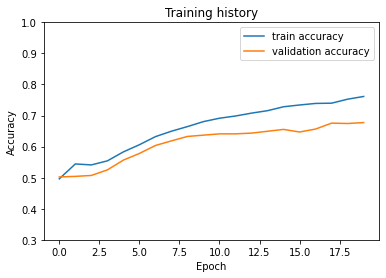

In [79]:
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.3, 1])

In [80]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []

    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2_full_clean.bin


100%|██████████| 1/1 [00:00<00:00,  2.48it/s]

              precision    recall  f1-score   support

     Neutral       0.60      0.27      0.37       386
    Positive       0.72      0.86      0.79       849
    Negative       0.60      0.67      0.63       445

    accuracy                           0.67      1680
   macro avg       0.64      0.60      0.60      1680
weighted avg       0.66      0.67      0.65      1680

